In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
data_dir = "../data/sessionSummaryCSV_7T/"

In [3]:
subj_list = np.load('subj_list.npy', allow_pickle=True)
print(len(subj_list))

176


In [4]:
runs_of_interest = [
    "BOLD_REST1_PA",
    "BOLD_MOVIE1_AP",
    "BOLD_MOVIE2_PA",
    "BOLD_REST4_AP",
    "BOLD_MOVIE3_PA",
    "BOLD_MOVIE4_AP"
]

In [5]:
def convert_to_secs(timestring):
    h, m, s = map(int, timestring.split(':'))
    return h*3600 + m*60 + s

In [6]:
time_data = pd.DataFrame()

for subj in subj_list:
    
    # Read in data
    f_name = data_dir + subj + "_all.csv"
    tmp = pd.read_csv(f_name)
    tmp.columns = tmp.columns.str.replace(' ', '')
    
    for run in runs_of_interest:
        
        # Save times
        AcquisitionTime = convert_to_secs(tmp[tmp.ScanDescription == run]["AcquisitionTime"].values[0])
        SessionDay = tmp[tmp.ScanDescription == run]["SessionDay"].values[0]
        Session = tmp[tmp.ScanDescription == run]["Session"].values[0]

        # Calculate time from localizer
        LocalizerTime = tmp.loc[(tmp["SessionDay"]==SessionDay) & (tmp["Session"]==Session) & (tmp["ScanType"]=="Localizer")].iloc[0]["AcquisitionTime"]
        TimeFromLocalizer = AcquisitionTime - convert_to_secs(LocalizerTime)
        
        time_data = time_data.append({"Subject": subj,
                                      "Run": run,
                                     "AcquisitionTime": AcquisitionTime,
                                     "SessionDay": SessionDay,
                                     "Session": Session,
                                     "TimeFromLocalizer": TimeFromLocalizer
                         }, ignore_index=True)

In [7]:
assert time_data.shape[0]==len(subj_list)*len(runs_of_interest), "Time_data is the wrong shape!"

In [8]:
time_data.head()

,AcquisitionTime,Run,Session,SessionDay,Subject,TimeFromLocalizer
0,37065.0,BOLD_REST1_PA,1.0,Day 1,100610,529.0
1,38361.0,BOLD_MOVIE1_AP,1.0,Day 1,100610,1825.0
2,40311.0,BOLD_MOVIE2_PA,1.0,Day 1,100610,3775.0
3,39467.0,BOLD_REST4_AP,4.0,Day 2,100610,273.0
4,40722.0,BOLD_MOVIE3_PA,4.0,Day 2,100610,1528.0


In [9]:
short_names = {
    "BOLD_REST1_PA": "REST1",
    "BOLD_MOVIE1_AP": "MOVIE1",
    "BOLD_MOVIE2_PA": "MOVIE2",
    "BOLD_REST4_AP": "REST4",
    "BOLD_MOVIE3_PA": "MOVIE3",
    "BOLD_MOVIE4_AP": "MOVIE4"
}

time_data["Run"]= time_data["Run"].replace(short_names)
time_data.head()

,AcquisitionTime,Run,Session,SessionDay,Subject,TimeFromLocalizer
0,37065.0,REST1,1.0,Day 1,100610,529.0
1,38361.0,MOVIE1,1.0,Day 1,100610,1825.0
2,40311.0,MOVIE2,1.0,Day 1,100610,3775.0
3,39467.0,REST4,4.0,Day 2,100610,273.0
4,40722.0,MOVIE3,4.0,Day 2,100610,1528.0


In [10]:
time_data.groupby("Run", sort=False)["TimeFromLocalizer"].mean()

Run
REST1      656.352273
MOVIE1    2033.636364
MOVIE2    3358.880682
REST4      298.664773
MOVIE3    1585.301136
MOVIE4    2859.528409
Name: TimeFromLocalizer, dtype: float64

In [11]:
time_data.groupby("Run", sort=False)["TimeFromLocalizer"].median()

Run
REST1      584.5
MOVIE1    1951.5
MOVIE2    3232.5
REST4      276.0
MOVIE3    1556.0
MOVIE4    2809.0
Name: TimeFromLocalizer, dtype: float64

In [12]:
time_data.groupby("Run", sort=False)["AcquisitionTime"].mean()

Run
REST1     52884.903409
MOVIE1    54631.278409
MOVIE2    55587.431818
REST4     42306.556818
MOVIE3    43593.193182
MOVIE4    44867.420455
Name: AcquisitionTime, dtype: float64

In [13]:
time_data.groupby("Run", sort=False)["AcquisitionTime"].std()

Run
REST1     17080.008429
MOVIE1    16988.600023
MOVIE2    17002.657153
REST4      9635.456589
MOVIE3     9632.617218
MOVIE4     9619.365867
Name: AcquisitionTime, dtype: float64

In [14]:
my_palette = {"REST1": "tab:gray", 
              "REST4": "tab:gray",
              "MOVIE1": "tab:purple",
              "MOVIE2": "tab:purple",
              "MOVIE3": "tab:purple",
              "MOVIE4": "tab:purple",
             }

In [15]:
time_data["AcquisitionTimeHrs"] = time_data["AcquisitionTime"]/60/60
time_data["TimeFromLocalizerMins"] = time_data["TimeFromLocalizer"]/60

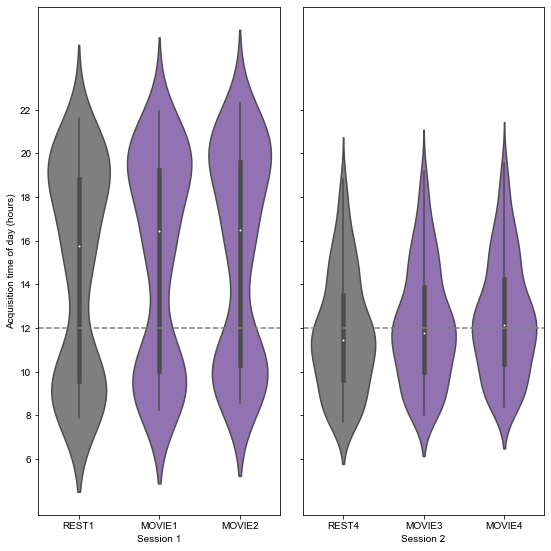

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,8), sharey=True)

# Do session 1
ax = ax1
order1 = ["REST1", "MOVIE1", "MOVIE2"]
sns.violinplot(x="Run", y="AcquisitionTimeHrs", 
               data=time_data[time_data["Run"].isin(order1)], 
               ax = ax, 
               palette=my_palette)

# Do session 2
ax = ax2
order2 = ["REST4", "MOVIE3", "MOVIE4"]
sns.violinplot(x="Run", y="AcquisitionTimeHrs", 
               data=time_data[time_data["Run"].isin(order2)], 
               ax = ax, 
               palette=my_palette)

sns.set(font_scale=1.5, style="white")
ax1.set_ylabel("Acquisition time of day (hours)")
ax1.set_xlabel('Session 1')
ax2.set_xlabel('Session 2')
ax2.yaxis.label.set_visible(False)

for ax in [ax1, ax2]:
    ax.axhline(y=12, ls='--', c='gray')
    ax.set_yticks(np.arange(6, 24, step=2))

fig.tight_layout()

In [17]:
time_data.groupby("Run", sort=False)["Session"].value_counts()

Run     Session
REST1   1.0        174
        2.0          2
MOVIE1  1.0        176
MOVIE2  1.0        174
        2.0          2
REST4   4.0        172
        5.0          4
MOVIE3  4.0        172
        5.0          4
MOVIE4  4.0        172
        5.0          4
Name: Session, dtype: int64

In [18]:
time_data.groupby("Run", sort=False)["SessionDay"].value_counts()

Run     SessionDay
REST1   Day 1         174
        Day 2           2
MOVIE1  Day 1         176
MOVIE2  Day 1         174
        Day 2           2
REST4   Day 2         103
        Day 3          73
MOVIE3  Day 2         103
        Day 3          73
MOVIE4  Day 2         103
        Day 3          73
Name: SessionDay, dtype: int64

#### How many subjects did a 3-day protocol versus a 2-day protocol?

In [19]:
time_data.groupby("Subject", sort=False)["SessionDay"].value_counts().groupby("Subject").count().value_counts()

2    174
3      2
Name: SessionDay, dtype: int64

In [28]:
time_data_wide = time_data.pivot(index='Subject', columns='Run', values=['AcquisitionTime', 'TimeFromLocalizer']).sort_index()
print(time_data_wide.shape)
time_data_wide.head()

(176, 12)


AcquisitionTime                                               \
Run              MOVIE1   MOVIE2   MOVIE3   MOVIE4    REST1    REST4   
Subject                                                                
100610          38361.0  40311.0  40722.0  42467.0  37065.0  39467.0   
102311          68544.0  69811.0  30108.0  31363.0  67027.0  28826.0   
102816          67498.0  68806.0  34842.0  36167.0  66083.0  33514.0   
104416          32136.0  35096.0  43979.0  45212.0  30833.0  42735.0   
105923          75770.0  77046.0  31282.0  32566.0  74416.0  30006.0   

        TimeFromLocalizer                                        
Run                MOVIE1  MOVIE2  MOVIE3  MOVIE4  REST1  REST4  
Subject                                                          
100610             1825.0  3775.0  1528.0  3273.0  529.0  273.0  
102311             2080.0  3347.0  1577.0  2832.0  563.0  295.0  
102816             2187.0  3495.0  1654.0  2979.0  772.0  326.0  
104416             2080.0  5040.0  1551.0  2784.0  777.0  307.0  
105923             1922.0  3198.0  1608.0  2892.0  568.0  332.0

In [29]:
time_data_wide.columns

MultiIndex([(  'AcquisitionTime', 'MOVIE1'),
            (  'AcquisitionTime', 'MOVIE2'),
            (  'AcquisitionTime', 'MOVIE3'),
            (  'AcquisitionTime', 'MOVIE4'),
            (  'AcquisitionTime',  'REST1'),
            (  'AcquisitionTime',  'REST4'),
            ('TimeFromLocalizer', 'MOVIE1'),
            ('TimeFromLocalizer', 'MOVIE2'),
            ('TimeFromLocalizer', 'MOVIE3'),
            ('TimeFromLocalizer', 'MOVIE4'),
            ('TimeFromLocalizer',  'REST1'),
            ('TimeFromLocalizer',  'REST4')],
           names=[None, 'Run'])

In [30]:
# Format TOD data for saving to csv
time_data_wide_copy = time_data_wide.copy()
time_data_wide_copy.columns = [x[1]+'_'+x[0] for x in time_data_wide.columns]
print(time_data_wide_copy.shape)
time_data_wide_copy.to_csv('../data/tod_data.csv')
time_data_wide_copy.head()

(176, 12)


,MOVIE1_AcquisitionTime,MOVIE2_AcquisitionTime,MOVIE3_AcquisitionTime,MOVIE4_AcquisitionTime,REST1_AcquisitionTime,REST4_AcquisitionTime,MOVIE1_TimeFromLocalizer,MOVIE2_TimeFromLocalizer,MOVIE3_TimeFromLocalizer,MOVIE4_TimeFromLocalizer,REST1_TimeFromLocalizer,REST4_TimeFromLocalizer
Subject,,,,,,,,,,,,
100610,38361.0,40311.0,40722.0,42467.0,37065.0,39467.0,1825.0,3775.0,1528.0,3273.0,529.0,273.0
102311,68544.0,69811.0,30108.0,31363.0,67027.0,28826.0,2080.0,3347.0,1577.0,2832.0,563.0,295.0
102816,67498.0,68806.0,34842.0,36167.0,66083.0,33514.0,2187.0,3495.0,1654.0,2979.0,772.0,326.0
104416,32136.0,35096.0,43979.0,45212.0,30833.0,42735.0,2080.0,5040.0,1551.0,2784.0,777.0,307.0
105923,75770.0,77046.0,31282.0,32566.0,74416.0,30006.0,1922.0,3198.0,1608.0,2892.0,568.0,332.0


Need to run the "helper_combine_behav_data" notebook before proceeding to the next cell.

In [31]:
all_behav = pd.read_csv('../data/all_behav.csv', dtype={'Subject': str})
all_behav.set_index('Subject', inplace=True)
print(all_behav.shape)
all_behav = all_behav.loc[time_data_wide.index,:].sort_index()
print(all_behav.shape)
all_behav.head()

(184, 665)
(176, 665)


,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,MOVIE3_AcquisitionTime,MOVIE4_AcquisitionTime,REST1_AcquisitionTime,REST4_AcquisitionTime,MOVIE1_TimeFromLocalizer,MOVIE2_TimeFromLocalizer,MOVIE3_TimeFromLocalizer,MOVIE4_TimeFromLocalizer,REST1_TimeFromLocalizer,REST4_TimeFromLocalizer
Subject,,,,,,,,,,,,,,,,,,,,,
100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,...,40722.0,42467.0,37065.0,39467.0,1825.0,3775.0,1528.0,3273.0,529.0,273.0
102311,S500,Q06,F,26-30,True,1,1,4,100.0,True,...,30108.0,31363.0,67027.0,28826.0,2080.0,3347.0,1577.0,2832.0,563.0,295.0
102816,Q3,Q03,F,26-30,True,1,1,4,100.0,True,...,34842.0,36167.0,66083.0,33514.0,2187.0,3495.0,1654.0,2979.0,772.0,326.0
104416,S900,Q09,F,31-35,True,2,2,4,100.0,True,...,43979.0,45212.0,30833.0,42735.0,2080.0,5040.0,1551.0,2784.0,777.0,307.0
105923,MEG2,Q07,F,31-35,True,2,2,4,100.0,True,...,31282.0,32566.0,74416.0,30006.0,1922.0,3198.0,1608.0,2892.0,568.0,332.0


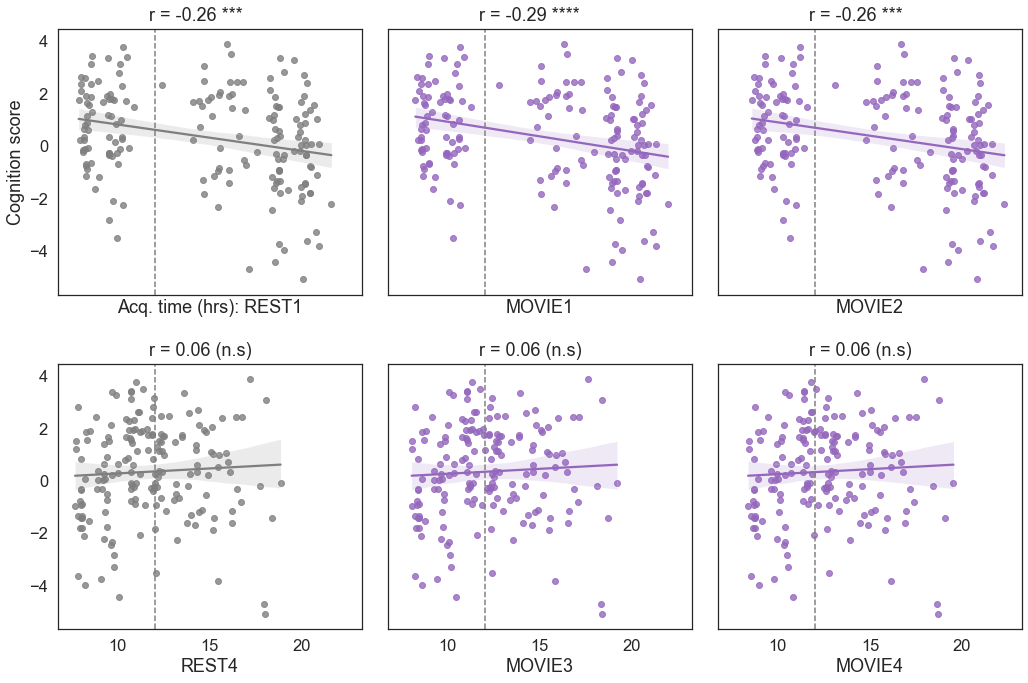

In [32]:
fig, axes = plt.subplots(2,3, figsize=(15,10), sharey=True, sharex=True)
axes = axes.flatten()

runs_of_interest = [
    "REST1",
    "MOVIE1",
    "MOVIE2",
    "REST4",
    "MOVIE3",
    "MOVIE4"
]


for r,run in enumerate(runs_of_interest):
    ax = axes[r]

    x = time_data_wide['AcquisitionTime'][run]/60/60
    y = all_behav["cogn_PC1"]

    if 'REST' in run:
        color = "tab:gray"
    if 'MOVIE' in run:
        color = "tab:purple"
    sns.regplot(x=x, y=y, ax=ax, color=color)
    rval,p = sp.stats.pearsonr(x,y)
    if p > 0.05:
        star = '(n.s)'
    elif 0.01 < p < 0.05:
        star = '*'
    elif 0.001 < p < 0.01:
        star = '**'
    elif 0.0001 < p < 0.001:
        star = '***'
    elif p < 0.0001:
        star = '****'
    ax.annotate(''.join(["r = ", "{:.2f} ".format(rval), star]), xy=(0.3, 1.03), xycoords='axes fraction')
    ax.set_xlabel(run.split('_')[0] + "_AcqTimeHrs")
    ax.axvline(x=12, ls='--', c='gray')
    
    if r==0:
        ax.set_ylabel('Cognition score')
        ax.set_xlabel('Acq. time (hrs): '+run.split('_')[0])
    if r>0:
        ax.set_ylabel('')
        ax.set_xlabel(run.split('_')[0])

sns.set(font_scale=2, style="white")
# fig.tight_layout(h_pad=3)
fig.tight_layout()

In [33]:
from scipy.stats import t, norm
from math import atanh, pow
from numpy import tanh

def rz_ci(r, n, conf_level = 0.95):
    zr_se = pow(1/(n - 3), .5)
    moe = norm.ppf(1 - (1 - conf_level)/float(2)) * zr_se
    zu = atanh(r) + moe
    zl = atanh(r) - moe
    return tanh((zl, zu))

def rho_rxy_rxz(rxy, rxz, ryz):
    num = (ryz-1/2.*rxy*rxz)*(1-pow(rxy,2)-pow(rxz,2)-pow(ryz,2))+pow(ryz,3)
    den = (1 - pow(rxy,2)) * (1 - pow(rxz,2))
    return num/float(den)

def dependent_corr(xy, xz, yz, n, twotailed=True, conf_level=0.95, method='steiger'):
    """
    Calculates the statistic significance between two dependent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between x and z
    @param yz: correlation coefficient between y and z
    @param n: number of elements in x, y and z
    @param twotailed: whether to calculate a one or two tailed test, only works for 'steiger' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'steiger' or 'zou'
    @return: t and p-val
    """
    if method == 'steiger':
        d = xy - xz
        determin = 1 - xy * xy - xz * xz - yz * yz + 2 * xy * xz * yz
        av = (xy + xz)/2
        cube = (1 - yz) * (1 - yz) * (1 - yz)

        t2 = d * np.sqrt((n - 1) * (1 + yz)/(((2 * (n - 1)/(n - 3)) * determin + av * av * cube)))
        p = 1 - t.cdf(abs(t2), n - 3)

        if twotailed:
            p *= 2

        return t2, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(xz, n, conf_level=conf_level)[0]
        U2 = rz_ci(xz, n, conf_level=conf_level)[1]
        rho_r12_r13 = rho_rxy_rxz(xy, xz, yz)
        lower = xy - xz - pow((pow((xy - L1), 2) + pow((U2 - xz), 2) - 2 * rho_r12_r13 * (xy - L1) * (U2 - xz)), 0.5)
        upper = xy - xz + pow((pow((U1 - xy), 2) + pow((xz - L2), 2) - 2 * rho_r12_r13 * (U1 - xy) * (xz - L2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

In [34]:
run_pairs=[("REST1", "MOVIE1"),
           ("REST1", "MOVIE2"),
           ("REST4", "MOVIE3"), 
           ("REST4", "MOVIE4")]

for pair in run_pairs:
    print(pair)
    
    run1 = pair[0]
    run2 = pair[1]

    x = all_behav["cogn_PC1"]
    y = time_data_wide['AcquisitionTime'][run1]
    z = time_data_wide['AcquisitionTime'][run2]

    xy = sp.stats.pearsonr(x,y)[0]
    xz = sp.stats.pearsonr(x,z)[0]
    yz = sp.stats.pearsonr(y,z)[0]

    print(dependent_corr(xy, xz, yz, n = len(x)))

('REST1', 'MOVIE1')
(1.7724174123604313, 0.0780853019576484)
('REST1', 'MOVIE2')
(1.2000364410213404, 0.23176595306052916)
('REST4', 'MOVIE3')
(0.9970675641683503, 0.32012426977441466)
('REST4', 'MOVIE4')
(0.28637704957922683, 0.7749320074400137)
